<a href="https://colab.research.google.com/github/fares-mldev/uns-pdi2021/blob/main/tp6/PDI_TP6_Convolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practico TP6 (Convolución)

Implementar un aplicativo que levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución para los siguientes filtros:

1. Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
2. Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
3. Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4

Respecto del “cierre” de la imagen cerca de los bordes, implementar la técnica no matemáticamente perfecta de “repetir” artificialmente filas o columnas cuando estas hagan falta. Por ejemplo, si el kernel es 3x3 y estoy en la primera columna, y no hay ninguna columna a la izquierda, entonces repito la primera columna como si estuviese en la imagen original. Otra opción es la conocida como padding en la cual adicionamos filas y columnas de ceros en los extremos de la imagen, similar al que les mostré para hacer que dos imágenes tengan el mismo tamaño.

Deben mostrar el aplicativo que permita cargar o seleccionar la imagen y elegir de una lista el filtro a aplicar ver su resultado. Adicionalmente deben mostrar un plot con todos los filtros aplicados para la imagen de entrada.

**Nota:** La función de convolución debe ser desarrollada por ustedes, NO mediante funciones de biblioteca.

In [2]:
#@title Imports

# Import numpy
import numpy as np

# Import imageio
import imageio as iio

# Import matplotlib
import matplotlib.pyplot as plt

# Import widgets
import ipywidgets as widgets
from IPython.display import display

# Install and import wget
!pip install wget
import wget


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=a21490771cb7ee69a22f124638c60cf80aa93ef713fb4665eb144ba33651cffa
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
#@title Image utils

# Images URL list 
url_dict = {}
url_dict["bacteria"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/bacteria.jpg"
url_dict["head"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/head.jpg"
url_dict["retina"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/retina.jpg"
url_dict["dlines"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/dlines.jpg"

def get_image(image: str, fn="") -> np.array:
    '''
    Downloads specified image from the web and returns it as a numpy array
    '''
    # Read image from file
    img = iio.imread(url_dict[image]+fn)

    # Return image
    return np.asarray(img)

# RGB to YIQ space transformation matrix
rgb_to_yiq = [[0.299, 0.587, 0.114],
              [0.595716, -0.274453, -0.321263],
              [0.211456, -0.522591, 0.311135]]

# YIQ to RGB space transformation matrix
yiq_to_rgb = [[1, 0.9663, 0.6210],
              [1, -0.2721, -0.6474],
              [1, -1.1070, 1.7046]]

def create_elipse(h=256,w=256,a=8,b=8):
  '''
  Creates a centred elipse
  '''
  # init image
  im = np.zeros((w,h))
  
  centre_h = int(h / 2)
  centre_w = int(w / 2)

  for row in range(h):
    for col in range(w):
      im[row,col] = int ((np.square(row-centre_h) / np.square(a) + np.square(col-centre_w) / np.square(b)) <= 1)

  return im

def plot_img(img: np.array, ax = None):
  '''
  Plots image using matplotlib 
  '''

  # If no axis sprecified get handle
  if ax is None:
    ax = plt.gca()

  # Show image
  ax.imshow(img)

def describe_img(img: np.array):
  '''
  Prints image properties
  '''
  print("Image shape (height,width,channels):", img.shape)
  print("Element type:", img.dtype)
  print("Total number of pixels:",img.size)
  print("Pixels per channel:", int(img.size/img.shape[2]))
  print("min-max value of channel 0:",img[:,:,0].min(),img[:,:,0].max())
  print("min-max value of channel 1:",img[:,:,1].min(),img[:,:,1].max())
  print("min-max value of channel 2:",img[:,:,2].min(),img[:,:,2].max())
  
def convert_rgb2yiq(img_rgb: np.array) -> np.array:
  '''
  Converts an RGB image to YIQ space
  '''
  
  # Normalize image
  img_rgb_n = img_rgb.astype(np.float64) / 255.0  
  
  # Apply transformation
  img_yiq = np.dot(img_rgb_n,rgb_to_yiq)
  
  # Clip to limits

  # Return YIQ image
  return img_yiq

def convert_yiq2rgb(img_yiq: np.array) -> np.array:
  '''
  Converts an YIQ image to RGB space
  '''

  # Apply transformation
  img_rgb_n= np.dot(img_yiq,yiq_to_rgb)
  
  # Clip image 
  img_rgb = img_rgb_n.clip(0,1) * 255.0
  
  # Return RGB image
  return img_rgb.astype(np.uint8) 

def get_y(im):
  '''
  Gets the luminance (Y) channel of an image
  '''
  return convert_rgb2yiq(im)[:,:,0]

def get_fft(im):
  '''
  Gets the magnitude and phase channels on an image
  '''
  fc = np.fft.fftshift(np.fft.fft2(im))

  mag = np.abs(fc)
  phase = np.angle(fc)

  return mag,phase

def get_ifft(fft_img):
    
  # reverse the 2D fourier transform
  img = np.fft.ifft2(np.fft.ifftshift(fft_img))
  img = np.abs(img)

  return img

def polar_to_rect(mag, phase):
  '''
  Recovers complex from magnitude and phase  
  '''
  return mag * np.exp(1j*phase)

def plot_fft(im, desc= '', type = 'log'):
  '''
  Plots an image, together with its fft magnitude and phase
  '''
  fig, axes = plt.subplots(1,3)
  fig.set_size_inches(21,7)
  mag, phase = get_fft(im)

  axes[0].imshow(im, cmap = 'gray')
  axes[0].set_title(desc)
  if type == 'log':
    axes[1].imshow(np.log(mag), cmap = 'gray')
  if type == 'sqrt':
    axes[1].imshow(np.power(mag,0.2), cmap = 'gray')
  
  axes[1].set_title('fft magnitude')
  axes[2].imshow(phase, cmap = 'gray')
  axes[2].set_title('fft phase')
  
def save_img(fn: str, im: np.array):
  '''
  Saves a image to disk
  '''
  # Clip and scale image 
  im = im.clip(0,1) * 255.0
  im = im.astype(np.uint8) 

  # Write to file
  iio.imwrite(fn,im)

def save_fig(fn):
  # Write results to file
  fig = plt.gcf()
  fig.savefig(fn)

def norm_img(im):
  '''
  Normalize image between 0 and 255.0
  '''
  return (im - np.min(im)) / (np.max(im) - np.min(im)) * 255.0

def plot_fft_mag(im, desc= '', type = 'log'):
  '''
  Plots an image, together with its fft magnitude 
  '''
  fig, axes = plt.subplots(1,2)
  fig.set_size_inches(10,5)
  mag, phase = get_fft(im)

  axes[0].imshow(im, cmap = 'gray')
  axes[0].set_title(desc)
  if type == 'log':
    axes[1].imshow(np.log(mag), cmap = 'gray')
  if type == 'sqrt':
    axes[1].imshow(np.power(mag,0.2), cmap = 'gray')
  
  axes[1].set_title('fft magnitude')

def save_img(fn: str, im: np.array):
  '''
  Saves a image to disk
  '''
  # Clip and scale image 
  im = im.clip(0,1) * 255.0
  im = im.astype(np.uint8) 

  # Write to file
  iio.imwrite(fn,im)

def save_fig(fn):
  # Write results to file
  fig = plt.gcf()
  fig.savefig(fn)

In [4]:
#@title Conv utils

def condition(im, ctype= "clip", invert= False):
  '''
  Apply signal conditioning
  '''
  assert ctype=="clip" or \
         ctype=="avg" or \
         ctype=="abs" or \
         ctype=="none", "Valid ctype values are 'clip', 'avg', 'abs' or 'none'" 

  # No conditioning
  if ctype=='none':
    return im
  
  if invert:
    im = -im.copy()
  
  # Stretch before conditioning  
  out = im / np.max(im)

  # Average
  if ctype == "avg":
    out = out / 2.0 + 0.5
  
  # Absolute
  if ctype == "abs":
    out = np.abs(out)
  
  # Clipping
  out = np.clip(out,0,1)

  return out 

def conv_2d(im, kernel):
  '''
  Perform convolution between an image and a 2d kernel
  '''

  # Prescale image
  im = im.copy() / im.max()

  # Get image shape
  im_h = im.shape[0] 
  im_w = im.shape[1] 

  # Get kernel shape
  k_h = kernel.shape[0]
  k_w = kernel.shape[1]

  # Remove central row-col and divide by 2
  pad_h = (k_h - 1) // 2
  pad_w = (k_w - 1) // 2
  
  # Create output image
  out = np.zeros(im.shape) 

  # Loop over rows
  for row in range(im_h):
    # Loop over cols
    for col in range(im_w):
      
      # Get sub image index ranges 
      range_w = range((col - pad_w), (col + pad_w + 1))
      range_h = range((row - pad_h), (row + pad_h + 1))
      
      # Clip to real indexes
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)
      
      # Slice image
      sub_im = im[np.ix_(idx_h,idx_w)]
      
      # Apply kernel
      out[row,col] = np.multiply(sub_im,kernel).sum()

  return out




In [5]:
#@title Low pass filters (code)

def k2d_lp(n):
  '''
  Defines a plain low pass kernel of size n x n
  '''
  
  # Assert that N is odd
  assert n%2 != 0, "n needs to be odd"
  assert n >= 3, "n needs to greater or equal than 3"

  # Create kernel
  k = np.ones([n,n])

  # Scale kernel
  k = k / k.sum()

  # Return kernel
  return k

def k1d_lp_bartlett(n):
  '''
  Obtain a 1d bartlett filet of size n (no scaling)
  ''' 
  # First get 1d kernel
  k1d = [(n+2)//2]
  for i in reversed(range(1,(n+2)//2)):
    k1d.append(i)
    k1d.insert(0,i)
  
  return k1d

def k2d_lp_bartlett(n):
  '''
  Defines a barlett low pass kernel of size N x N
  '''

  # Assert that N is odd
  assert n%2 != 0, "N needs to be odd"
  assert n >= 3, "N needs to greater or equal than 3"

  # First get 1d kernel
  k1d = [(n+2)//2]
  for i in reversed(range(1,(n+2)//2)):
    k1d.append(i)
    k1d.insert(0,i)
  
  # Now perform outer product to get the 2d kernel
  k2d = np.outer(k1d,k1d)
  k2d = k2d / k2d.sum()

  # Return kernel
  return k2d

def binom(n, k):
  '''
  Calculates binomial coefficient
  '''
  value = 1
  for i in range(k):
      value = (value * (n - i)) // (i + 1)
  return value

def pascal(n):
  '''
  Calculates n-th row of pascal triangle
  i-th value of n-th row is binom(n-1,i)
  '''
  assert n>0, "nrow must be > 0"
  return [binom(n-1,i) for i in range(n)]

def k2d_lp_gaussian(n):
  '''
  Defines a gaussian low pass kernel of size n x n
  '''

  # Assert that N is odd
  assert n%2 != 0, "N needs to be odd"
  assert n >= 3, "N needs to greater or equal than 3"

  # First get 1d kernel
  k1d = pascal(n)
  
  # Now perform outer product to get the 2d kernel
  k2d = np.outer(k1d,k1d)
  k2d = k2d / k2d.sum()

  # Return kernel
  return k2d


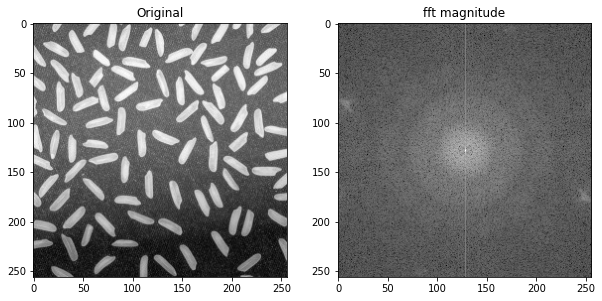

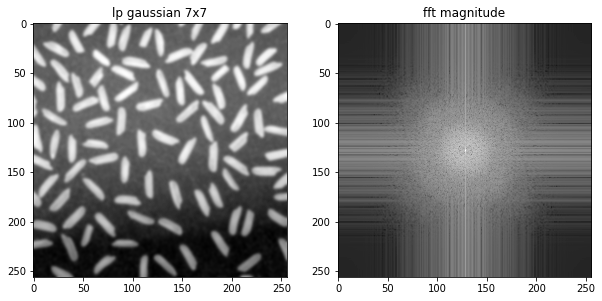

In [6]:
#@title Low pass filters test { run: "auto" }

# Get image
image = "circle" #@param ["bacteria","head","retina","circle"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

filter = "lp gaussian" #@param ["lp","lp bartlett","lp gaussian"]
kernel_size = "7" #@param [3,5,7]
#contitioning = "clip" #@param ["clip","avg","abs"]

# Select kernel
k = []

if filter == "lp":
  k = k2d_lp(np.int(kernel_size))

if filter == "lp bartlett":
  k = k2d_lp_bartlett(np.int(kernel_size))

if filter == "lp gaussian":
  k = k2d_lp_gaussian(np.int(kernel_size))

im_filt = conv_2d(im, k)
im_cond = condition(im_filt)

plot_fft_mag(im, desc= 'Original')
plot_fft_mag(im_cond, desc= filter + " " + \
                            kernel_size + "x" + kernel_size)


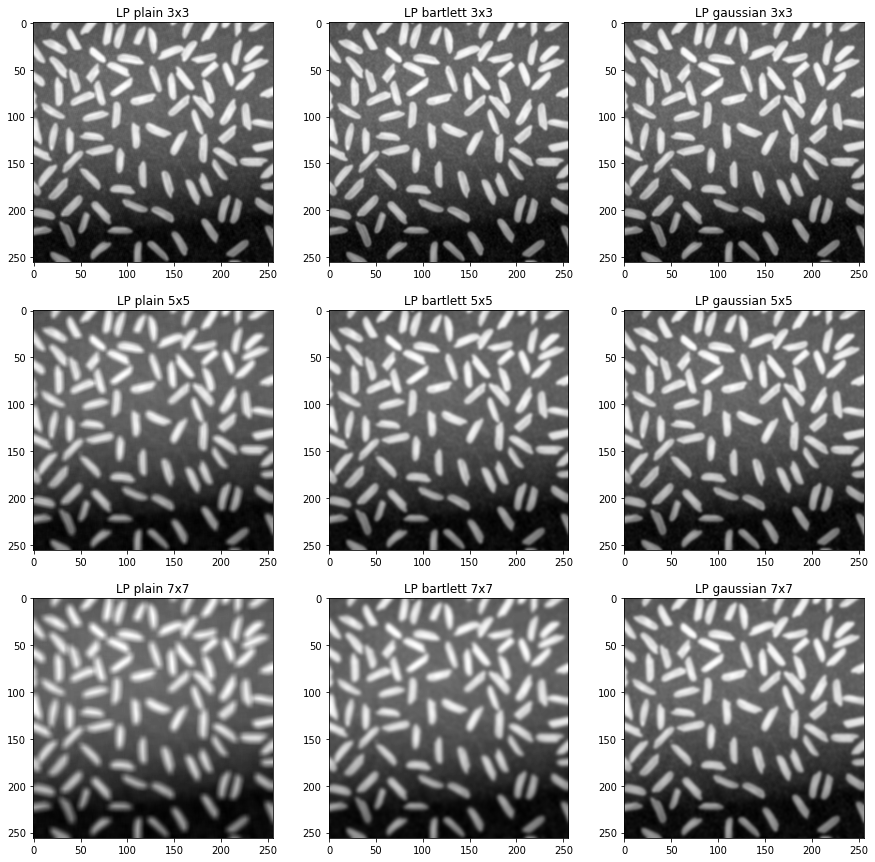

In [37]:
#@title Low pass filters comparison { run: "auto" }

#@markdown Se observa que a medida que aumenta el tamaño de kernel, el efecto de filtrado es mas fuerte.

#@markdown El pasabajos plano tiene un efecto mayor que el bartlett, y a su vez mayor al gaussiano al mismo tamaño de kernel.


# Get image
image = "bacteria" #@param ["bacteria","head","retina","circle"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

# Create figure
fig, axes = plt.subplots(3,3)
fig.set_size_inches(15,15)

for idx, kernel_size in enumerate([3,5,7]): 

  # Low pass plain
  k = k2d_lp(np.int(kernel_size))
  im_filt = conv_2d(im, k)
  im_cond = condition(im_filt)

  axes[idx,0].imshow(im_cond, cmap='gray')
  axes[idx,0].set_title("LP plain " + str(kernel_size) + "x" + str(kernel_size))

  # Low pass bartlett
  k = k2d_lp_bartlett(np.int(kernel_size))
  im_filt = conv_2d(im, k)
  im_cond = condition(im_filt)

  axes[idx,1].imshow(im_cond, cmap='gray')
  axes[idx,1].set_title("LP bartlett " + str(kernel_size) + "x" + str(kernel_size))

  # Low pass gaussian
  k = k2d_lp_gaussian(np.int(kernel_size))
  im_filt = conv_2d(im, k)
  im_cond = condition(im_filt)

  axes[idx,2].imshow(im_cond, cmap='gray')
  axes[idx,2].set_title("LP gaussian " + str(kernel_size) + "x" + str(kernel_size))


In [14]:
#@title High pass filters (code)

def k2d_hp_lap(n):
  '''
  Defines a laplacian high pass kernel of size 3 x 3 with n neighbours
  '''
  assert n==4 or n==8, "n must be 4 or 8"

  if n == 4:
    k = [[0,-1,0],[-1,4,-1],[0,-1,0]]
  
  if n == 8:
    k = [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]
  
  return np.array(k)

def k2d_hp_sobel(orient = 0):
  '''
  Defines a sobel filter of size 3 x 3 of specified orientation
  '''

  # calculate orientation in radians
  orient_rad = 2 * np.pi * orient / 360.0 
  
  # calculate x and y components
  kx = [[-1,0,1],[-2,0,2],[-1,0,1]]
  ky = [[1,2,1],[0,0,0],[-1,-2,-1]]
  
  # apply orientation
  k = np.cos(orient_rad) * np.array(kx) + np.sin(orient_rad) * np.array(ky)
  
  # normalize
  k = k / np.sqrt(2)

  # set small values to 0
  eps = 1e-10
  k[np.abs(k) < eps ] = 0

  return k

def k1d_hp(f = 0.2):
  '''
  Defines a 1x5 filter with cutoff frequency f = 0.2 or 0.4
  '''
  
  assert (f == 0.2) or (f == 0.4) 

  k = [0,0,0,0,0]

  if f == 0.2:
    k = [-1,0,2,0,-1]

  if f == 0.4:
    k = [0,-1,2,-1,0]
  
  return np.array(k)


def k1d_hp2(f = 0.2):
  '''
  Defines a 1x5 filter with cutoff frequency f = 0.2 or 0.4
  '''
  
  assert (f == 0.2) or (f == 0.4) 

  k = [0,0,0,0,0]

  if f == 0.2:
    k = [1, -4, 6, -4, 1]

  if f == 0.4:
    k = [-1, -4, 10, -4, -1]
  
  return np.array(k)

def k2d_hp(f = 0.2):
  '''
  Defines a 5x5 filter with cutoff frequency f = 0.2 or 0.4
  '''

  k = np.outer(k1d_hp2(f),k1d_hp2(f))

  return k

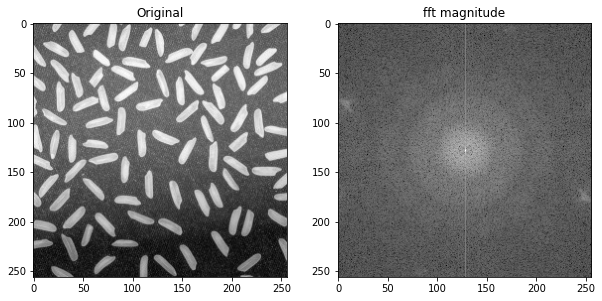

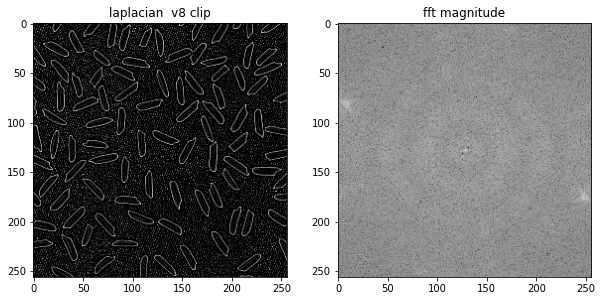

In [46]:
#@title High pass filters test: Laplacian { run: "auto" }

# Get image
image = "bacteria" #@param ["bacteria","head","retina","circle"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

filter = "laplacian"
version = "8" #@param [4,8]
contitioning = "clip" #@param ["clip","avg","abs"]

# Select kernel
k = k2d_hp_lap(np.int(version))

im_filt = conv_2d(im, k)
im_cond = condition(im_filt,ctype=contitioning)

plot_fft_mag(im, desc= 'Original')
plot_fft_mag(im_cond, desc= filter + "  v" + \
                            version + " " + contitioning)

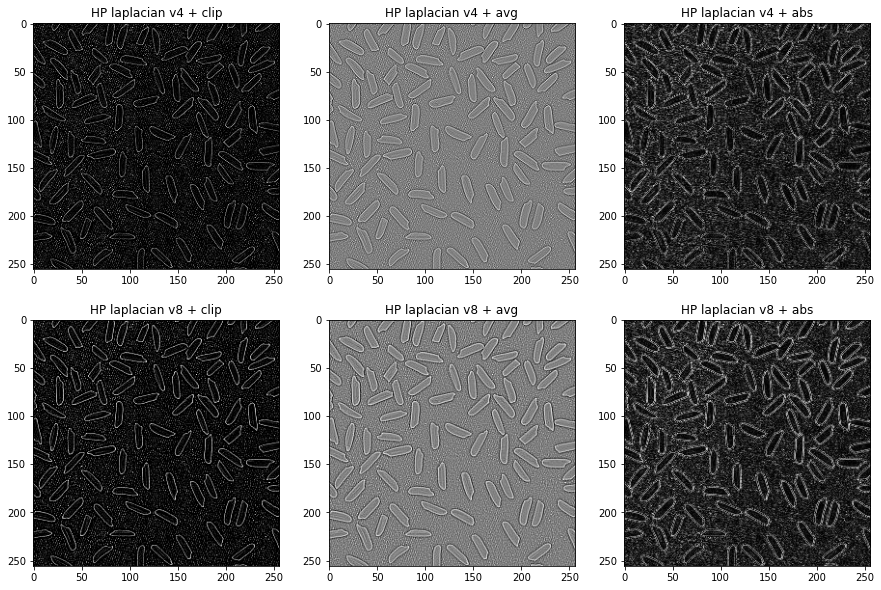

In [47]:
#@title High pass laplacian -  comparison { run: "auto" }
#@markdown Se observa una buena performance en cuanto a la detección de bordes, aunque con sensibilidad al ruido de fondo de la imagen.

#@markdown El mejor resultado observado es v8 + clipping.


# Get image
image = "bacteria" #@param ["bacteria","head","retina","circle"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

# Create figure
fig, axes = plt.subplots(2,3)
fig.set_size_inches(15,10)


for idxv, version in enumerate([4,8]): 
  for idxc, contitioning in enumerate(["clip","avg","abs"]): 
    
    # High pass laplacian
    k = k2d_hp_lap(np.int(version))

    im_filt = conv_2d(im, k)
    im_cond = condition(im_filt,ctype=contitioning)

    axes[idxv,idxc].imshow(im_cond, cmap='gray')
    axes[idxv,idxc].set_title("HP laplacian v" + str(version) + " + " + str(contitioning))



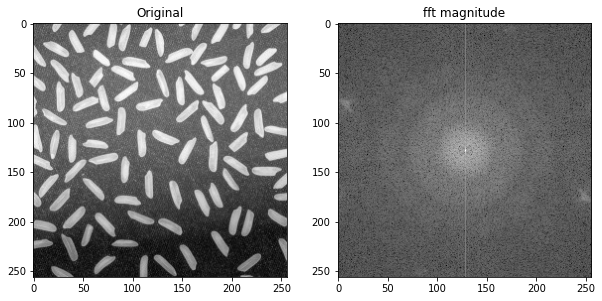

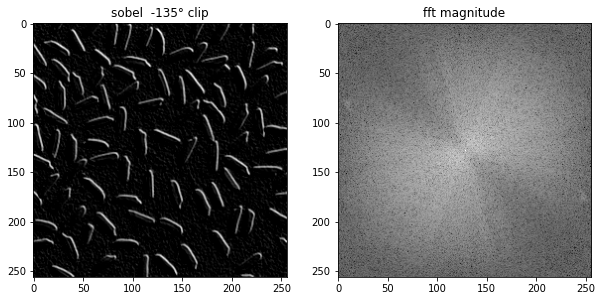

In [49]:
#@title High pass filters test: Sobel II { run: "auto" }

image = "bacteria" #@param ["bacteria","head","retina","circle"]
filter = "sobel"
orient =  -135 #@param {type:"slider", min:-180, max:180, step:5}
contitioning = "clip" #@param ["clip","avg","abs"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

# Select kernel
k = k2d_hp_sobel(orient=orient)

im_filt = conv_2d(im, k)
im_cond = condition(im_filt,ctype=contitioning)

plot_fft_mag(im, desc= 'Original')
plot_fft_mag(im_cond, desc= filter + "  " + \
                            str(orient) + "° " + contitioning)

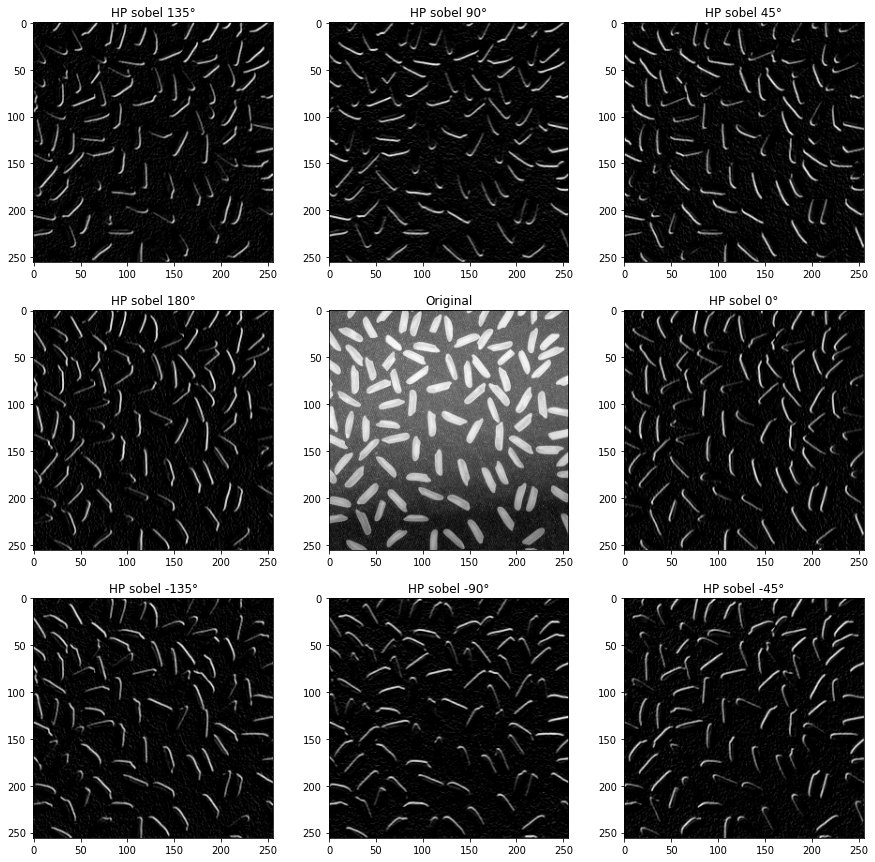

In [48]:
#@title High pass sobel -  comparison { run: "auto" }
#@markdown Se observa una buena performance en cuanto a la detección de bordes en una dirección determinada.

#@markdown Si bien se muestran 8 orientaciones, la implementación admite detectar ángulos arbitrarios.


# Get image
image = "bacteria" #@param ["bacteria","head","retina","circle"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

# Create figure
fig, axes = plt.subplots(3,3)
fig.set_size_inches(15,15)


orients = np.array([ [135,   90,   45],
            [180,    0,    0],
            [-135, -90,  -45] ])

for row in range(3): 
  for col in range(3): 

    # High pass laplacian
    k = k2d_hp_sobel(orient=orients[row,col])

    im_filt = conv_2d(im, k)
    im_cond = condition(im_filt,ctype='clip')

    axes[row,col].imshow(im_cond, cmap='gray')
    axes[row,col].set_title("HP sobel " + str(orients[row,col]) + "°")

  axes[1,1].imshow(im, cmap='gray')
  axes[1,1].set_title("Original")


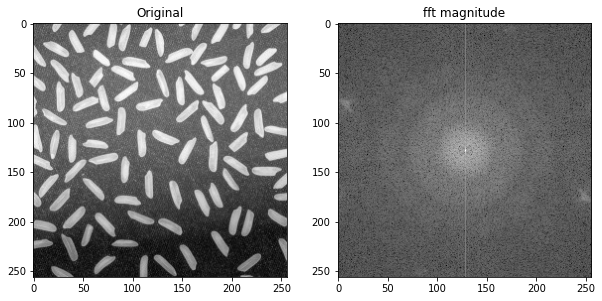

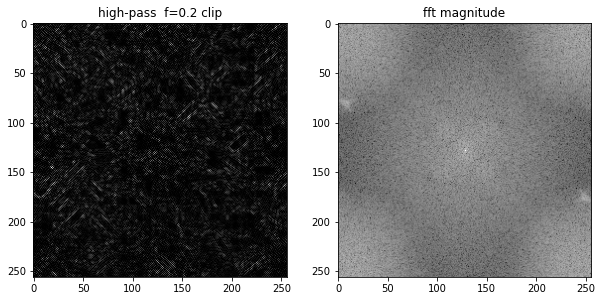

In [ ]:
#@title High pass filters test: cutoff { run: "auto" }

image = "bacteria" #@param ["bacteria","head","retina","dlines"]
filter = "high-pass"
f =  "0.2" #@param ["0.2","0.4"]
contitioning = "avg" #@param ["clip","avg","abs"]

# Get image
im = get_y(get_image(image))

# Select kernel
k = k2d_hp(f=np.float(f))

im_filt = conv_2d(im, k)
im_cond = condition(im_filt,ctype=contitioning)

plot_fft_mag(im, desc= 'Original')
plot_fft_mag(im_cond, desc= filter + "  f=" + \
                            f + " " + contitioning)

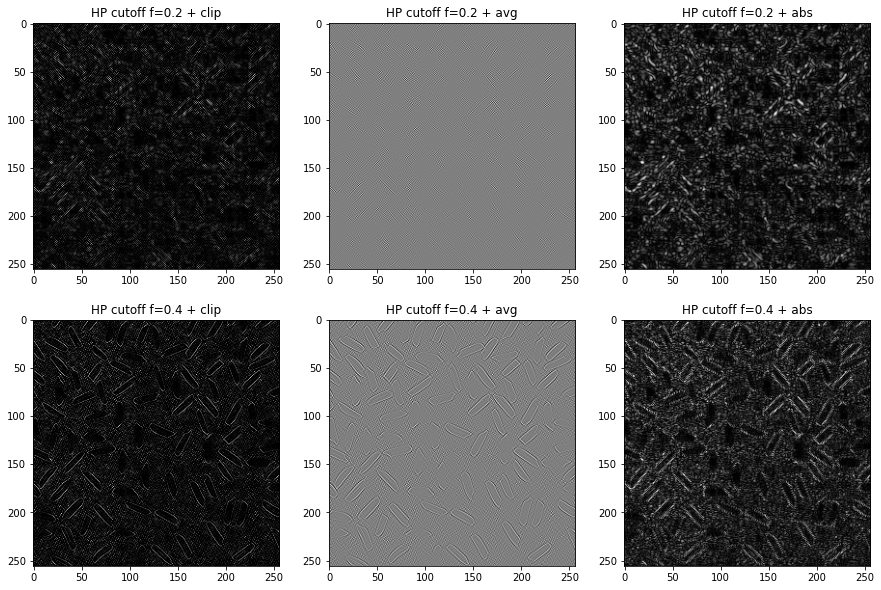

In [39]:
#@title High pass cutoff -  comparison { run: "auto" }

#@markdown No se observa una buena performance en la detección de bordes en ninguna de las frecuencias de corte.

# Get image
image = "bacteria" #@param ["bacteria","head","retina","circle"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

# Create figure
fig, axes = plt.subplots(2,3)
fig.set_size_inches(15,10)


for idxv, f in enumerate([0.2,0.4]): 
  for idxc, contitioning in enumerate(["clip","avg","abs"]): 
    
    # High pass cutoff
    k = k2d_hp(f=np.float(f))

    im_filt = conv_2d(im, k)
    im_cond = condition(im_filt,ctype=contitioning)

    axes[idxv,idxc].imshow(im_cond, cmap='gray')
    axes[idxv,idxc].set_title("HP cutoff f=" + str(f) + " + " + str(contitioning))

In [41]:
#@title Band pass filters (code)

def k2d_bp(n):
  '''
  Defines a band pass kernel of size n x n as a substraction 
  of a 0 padded n-2 x n-2 batlett and a n x n gaussian filter 
  '''
  
  # Get a n gaussian low pass filter
  k1d_gauss = pascal(n)
  k2d_gauss = np.outer(k1d_gauss,k1d_gauss)
  gauss_gain = k2d_gauss.sum()  
  k2d_gauss = k2d_gauss / gauss_gain

  # Get a n-2 bartlett low pass filter
  k1d_bart = k1d_lp_bartlett(n-2)
  k1d_bart = np.pad(k1d_bart , (1, 1), 'constant')
  k2d_bart = np.outer(k1d_bart,k1d_bart)
  bart_gain = k2d_bart.sum()
  k2d_bart = k2d_bart / bart_gain

  # Substract filters
  k = k2d_bart - k2d_gauss

  return np.array(k)


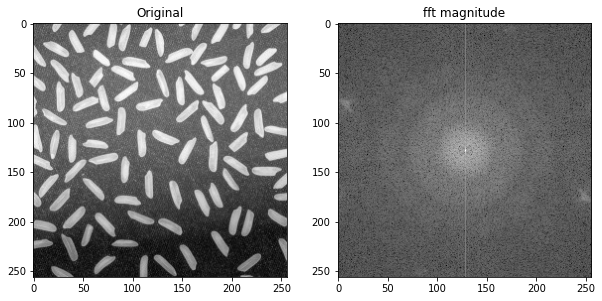

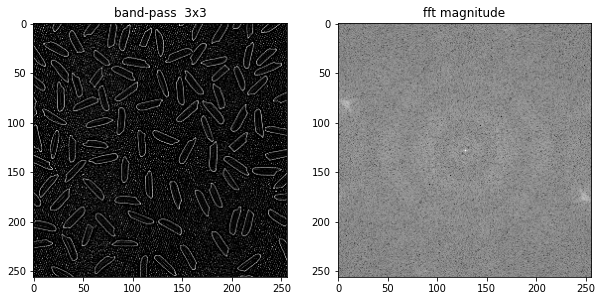

In [42]:
#@title Band pass filters test { run: "auto" }

image = "bacteria" #@param ["bacteria","head","retina","dlines"]
filter = "band-pass"
kernel_size =  "3" #@param [3,5,7]
contitioning = "clip" #@param ["clip","avg","abs"]

# Get image
im = get_y(get_image(image))

# Select kernel
k = k2d_bp(np.int(kernel_size))

im_filt = conv_2d(im, k)
im_cond = condition(im_filt,ctype=contitioning)

plot_fft_mag(im, desc= 'Original')
plot_fft_mag(im_cond, desc= filter + "  " + \
                            kernel_size + "x" + kernel_size)

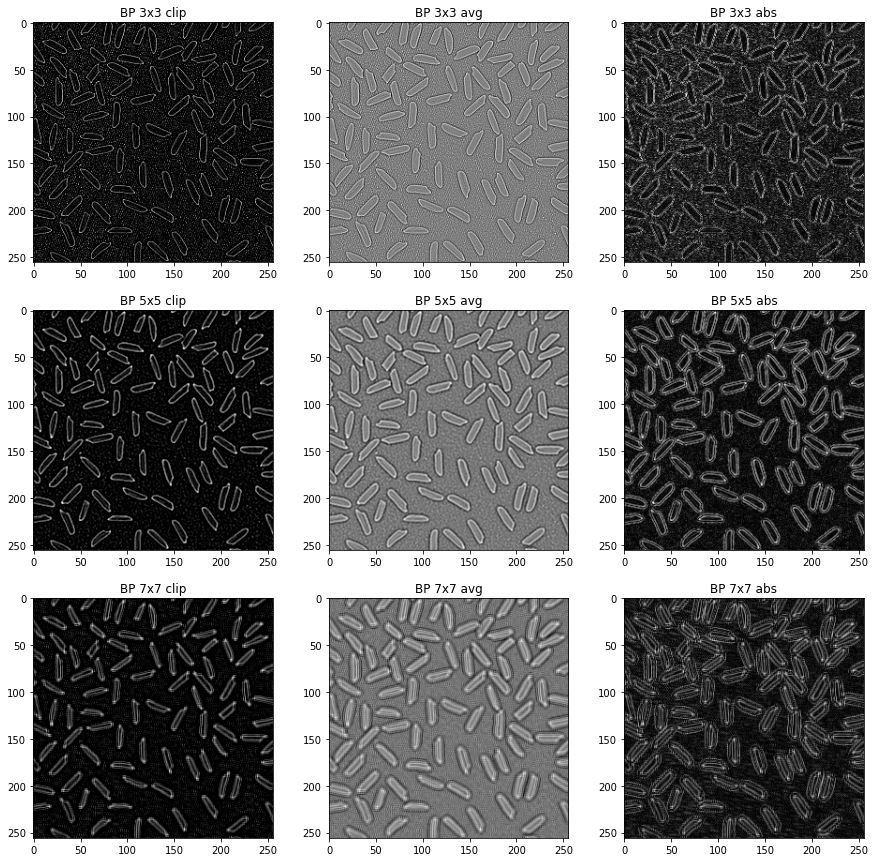

In [45]:
#@title Band pass -  comparison { run: "auto" }
#@markdown A medida que el tamaño del filtro aumenta, se aprecia mayor espesor en la detección del borde

#@markdown Se observa una buena performance en el 5x5 + clipping.

# Get image
image = "bacteria" #@param ["bacteria","head","retina","circle"]

if image == "circle":
  im = create_elipse(a=20,b=20)
else:
  # Get image
  im = get_y(get_image(image))

# Create figure
fig, axes = plt.subplots(3,3)
fig.set_size_inches(15,15)

for idxv, kernel_size in enumerate([3,5,7]): 
  for idxc, contitioning in enumerate(["clip","avg","abs"]): 
    
    # Band pass laplacian
    k = k2d_bp(np.int(kernel_size))

    im_filt = conv_2d(im, k)
    im_cond = condition(im_filt,ctype=contitioning)

    axes[idxv,idxc].imshow(im_cond, cmap='gray')
    axes[idxv,idxc].set_title("BP " + str(kernel_size) + "x" + str(kernel_size) + " " + str(contitioning))